### Student Name : Sajin Mohamed Pallikkathodi Erathali  
### Student Id : 23037601  
### Student Name : Akshata BheemasamudraMallikarjunappa  
### Student Id : 23164204  

## The code executes completely without any error. We have implemented 3 versions of Deep Q Network.  
1. Vanilla DQN
2. Fixed DQN
3. Double DQN

# The following are some of the implementations we have adopted to obtain the results.  
1. Github:nitish-kalan. (2023). MountainCar-v0-Deep-Q-Learning-DQN-Keras: train_model.py. [Online]. Available at: https://github.com/nitish-kalan/MountainCar-v0-Deep-Q-Learning-DQN-Keras/blob/master/train_model.py [Accessed: 25 March, 2024].
2. Kaggle. (2020). Core SP20 RL Notebook. [Online]. Available at: https://www.kaggle.com/code/ucfaibot/core-sp20-rl/notebook [Accessed: 19 March, 2024].
3. Kaggle. (2020). Mountain Car is a Classic Reinforcement Learning Problem Notebook. [Online]. Available at: https://www.kaggle.com/code/rezafazel63/mountain-car-is-a-classic-reinforcement-learning/notebook [Accessed: 20 March, 2024].
4. Github:pylSER. (2021). Deep-Reinforcement-learning-Mountain-Car: MountainCarV2.py. [Online]. Available at: https://github.com/pylSER/Deep-Reinforcement-learning-Mountain-Car/blob/master/MountainCarV2.py [Accessed: 27 March, 2024].
5. rlpy. (2022). MountainCar.py. [Online]. Available at: https://github.com/rlpy/rlpy/blob/master/rlpy/Domains/MountainCar.py [Accessed: April 1, 2024].

# 1. Vanilla DQN

In [3]:
# Installing gym environment version 0.21.0
!pip install 'gym [atari,accept-rom-license]==0.21.0'


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Importing packages and libraries

In [16]:
import os
os.environ['SDL_VIDEODRIVER'] = 'dummy'
import gym
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import pygame
from packaging import version
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.15.0")

import random
from collections import deque

In [17]:
random.seed(2212)
np.random.seed(2212)
tf.random.set_seed(2212)

## Hyperparameters

In [18]:
# The number of sequential interacgtions the car has with its environment.
EPISODES = 600
# The size of the experience replay (section ---)
REPLAY_MEMORY_SIZE = 1_00_000
# Minimum size of experience replay required
MINIMUM_REPLAY_MEMORY = 1_000
# The number of sample we fetch from the experience replay during training
MINIBATCH_SIZE = 32
# The hyperparameter which balances exploration and exploitation by agent
EPSILON = 0.1
# The rate at which the epsilon decreases
EPSILON_DECAY = 0.99
MINIMUM_EPSILON = 0.001
# The discount factor which doiscunts future reward in favor of immediate reward (gamma)
DISCOUNT = 0.99
# The simulated environment used by the agent (car)
ENV_NAME = 'MountainCar-v0'

## Defining environment

In [19]:
# creates an environment
env = gym.make(ENV_NAME)
# Returns dimensionality of action space (0-> push left, 1-> no acceleration, 2-> push right)
action_dim = env.action_space.n
# Returns dimensionality of observation space (position [-1.2, 0.6], velocity[-0.07,0.07])
observation_dim = env.observation_space.shape

## Defining Deep Q Network model

A sequential model with 400 input neurons and 300 neurons in the hidden layer and 3 in the output layer

In [20]:
# Creating simple sequential neural network model with 3 layers (400, 300, 2)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(400, activation='relu', input_shape=observation_dim),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(action_dim, activation='linear')
])

'''Compiling the neural network using Mean Square Error as loss function and
Adam as the optimizer which will learn at a rate of 0.005'''
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))



## Defining Epsilon greedy policy (section 5.1)

In [21]:
'''Defining epsilon greedy policy function to determine an action
to decide whether to explore or exploit the knowledge acquired'''
def epsilon_greedy_policy(state, epsilon):
    # Explore if random value from uniform distribution is less than exploration factor epsilon
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, action_dim)
        return action
    else:
    # Exploit
        action = np.argmax(model.predict(np.expand_dims(state, axis=0), verbose=0)[0])
        return action

## Defining the sample experience (section 2.1.1)

In [22]:
# Replay memory (experience replay) to store experiances of the model with the environment
replay_buffer = deque(maxlen=REPLAY_MEMORY_SIZE)

'''This function samples a minibatch of experiences from the replay buffer for training the model.'''
def sample_experience(MINIBATCH_SIZE):
    # random sampling  batch size(32) number of values from the replay buffer
    minibatch = random.sample(replay_buffer, MINIBATCH_SIZE)
    # list to store the current state
    X_cur_states = []
    # list to store the next state
    X_next_states = []

    # populating the current and next states list
    for index, sample in enumerate(minibatch):
        cur_state, action, reward, next_state, done = sample
        X_cur_states.append(cur_state)
        X_next_states.append(next_state)

    # converting into arrays
    X_cur_states = np.array(X_cur_states)
    X_next_states = np.array(X_next_states)
    return minibatch,X_cur_states,X_next_states

## Defining the step function

In [23]:
max_reward = -999999


'''This function defines the steps the agent has to take based on the epsilon greedy policy
 and accumulates the reward'''
def play_one_step(env, state, epsilon, episode_length):
    # defining reward acquired in each episode
    global episode_reward
    # Calling epsilon greedy function to select action
    action = epsilon_greedy_policy(state, epsilon)
    # Executing the action and returns 4 values
    next_state, reward, done, info = env.step(action)
    # accumulating rewards in each step of the epsiode(max=-200)
    episode_reward += reward
    # truncating if the car reaches the flag on the mountain top within 200 steps
    if done and episode_length < 200:
        # If episode is ended then we have won the game. Defining Stratagem to make the agent learn faster
        reward = 250 + episode_reward
        # save the model weights if we get a epsiode reward greater than maximum reward defined
        if(episode_reward > max_reward):
            print("Saving the model with reward", episode_reward)
            model.save_weights("agent"+str(episode_reward)+"_agent_.weights.h5")
    else:
        # In oher cases reward will be proportional to the distance that car has travelled
        # from it's previous location + velocity of the car
        reward = 5*abs(next_state[0] - state[0]) + 3*abs(state[1])

    # append this result to the replay buffer(experince replay)
    replay_buffer.append((state, action, reward, next_state, done))

    return next_state, episode_reward, max_reward, done, info

## Defining the training function(Section 2.1)

In [25]:
rewards = []
'''The function creates and updates the q table and updates the model weights based on the Bellman's equation'''
def training_step(MINIBATCH_SIZE):
    # retrieving the array of values from the replay buffer
    minibatch, X_cur_states, X_next_states = sample_experience(MINIBATCH_SIZE)
    # predict state action values
    cur_action_values = model.predict(X_cur_states, verbose=0)

    # action values for the next_states taken from our agent (Q network)
    next_action_values = model.predict(X_next_states, verbose=0)

    for index, sample in enumerate(minibatch):

        cur_state, action, reward, next_state, done = sample
        # estimate the optimal state action values
        if not done:
            # Bellman's optimality equation
            '''A way to estimate the optimal state value of any state s(Q(st, at)) = sum of all discounted future rewards the agent can expect on average after it reaches a state s, assuming it acts optimally'''
            # Q(st, at) = reward + DISCOUNT * max(Q(s(t+1), a(t+1)))
            cur_action_values[index][action] = reward + DISCOUNT * np.amax(next_action_values[index])
        else:
            # Q(st, at) = reward
            cur_action_values[index][action] = reward

    # train the agent with new Q values for the states and the actions
    model.fit(X_cur_states, cur_action_values, verbose=0)




## Running the episodes

In [26]:
# Looping through episodes
for episode in range(EPISODES):
    # resetting the environment for the state to be reset
    state = env.reset()
    # initializing variables used
    done = False
    episode_reward = 0
    episode_length = 0

    # Running through different sets of steps
    while not done:
        # incrementing episode length(number of steps)
        episode_length += 1
        # calling the play_one_step function to execute the steps
        next_state, reward, max_reward, done, info  = play_one_step(env,state, EPSILON, episode_length)
        # update the current state with the next state for the episode to continue
        state = next_state

        # Checking if the replay buffer size is less than the minimum required replay buffer size for training to start
        if(len(replay_buffer) < MINIMUM_REPLAY_MEMORY):
            continue
        # when the minimum replay buffer size is populated
        training_step(MINIBATCH_SIZE)


    # recording the values for visualizing the results
    max_reward = max(reward, max_reward)
    print('Episode', episode, 'Episodic Reward', reward, 'Maximum Reward', max_reward, 'EPSILON', EPSILON)
    rewards.append(reward)

    # Epsilon decay for the next episode
    if(EPSILON > MINIMUM_EPSILON and len(replay_buffer) > MINIMUM_REPLAY_MEMORY):
        EPSILON *= EPSILON_DECAY

Episode 0 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 1 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 2 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 3 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 4 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 5 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 6 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.099
Episode 7 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.09801
Episode 8 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.0970299
Episode 9 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.096059601
Episode 10 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.09509900499
Episode 11 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.0941480149401
Episode 12 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.093206534790699
Episode 13 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.0922

## Plotting Rewards vs Episodes

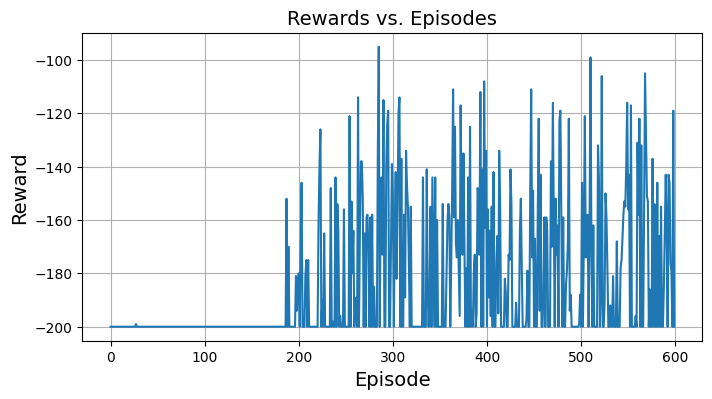

In [27]:
# model.set_weights(best_weights)
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.title("Rewards vs. Episodes", fontsize=14)
plt.grid(True)
plt.show()

# Plotting Moving Average over 50 episodes

Text(0.5, 1.0, 'Moving average over 50 episodes')

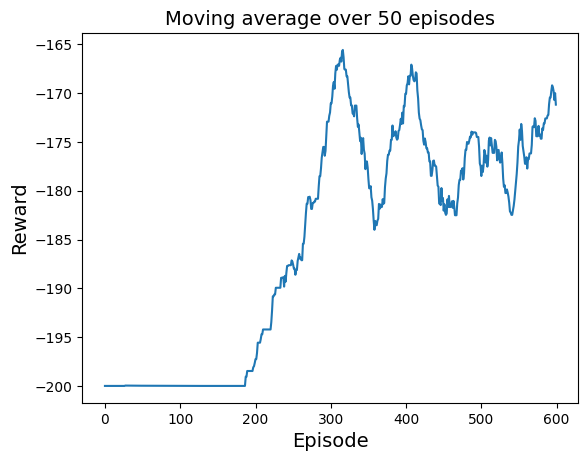

In [28]:
mean_rewards = np.zeros(600)
for t in range(600):
    mean_rewards[t] = np.mean(rewards[max(0, t-50):(t+1)])
plt.plot(mean_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.title("Moving average over 50 episodes", fontsize=14)

## Testing the pre-trained model for 50 episodes

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
class DQNAgent:
    def __init__(self, action_dim, observation_dim):
        # Force keras to use the session that we have created

        self.action_dim = action_dim
        self.observation_dim = observation_dim
        self.model = self.create_model()

    def create_model(self):
        state_input = Input(shape=(self.observation_dim))
        state_h1 = Dense(400, activation='relu')(state_input)
        state_h2 = Dense(300, activation='relu')(state_h1)
        output = Dense(self.action_dim, activation='linear')(state_h2)
        model = Model(inputs=state_input, outputs=output)
        model.compile(loss='mse', optimizer=Adam(0.005))
        return model

In [ ]:
# Loading the model weights
model_weight_file = 'agent-115.0_agent_.weights.h5'

# Creating the environment
env = gym.make('MountainCar-v0')

# Getting the action and observation space
action_dim = env.action_space.n
observation_dim = env.observation_space.shape

# create and load weights of the model
agent = DQNAgent(action_dim, observation_dim)
agent.model.load_weights(model_weight_file)
# Number of episodes in which agent manages to won the game before time is over
episodes_won = 0
# Number of episodes for which we want to test the agnet
TOTAL_EPISODES = 50

# Looping through the episodes
for _ in range(TOTAL_EPISODES):
    cur_state = env.reset()
    done = False
    episode_len = 0
    while not done:

        episode_len += 1
        # Taking the action based on the model prediction
        next_state, reward, done, _ = env.step(np.argmax(agent.model.predict(np.expand_dims(cur_state, axis=0), verbose=0)))
        if done and episode_len < 200:
            episodes_won += 1
        cur_state = next_state

# Printing the number of episodes won by the agent
print(episodes_won, 'EPISODES WON AMONG', TOTAL_EPISODES, 'EPISODES')

48 EPISODES WON AMONG 50 EPISODES


<span style="color:green">This shows the game has reached the done state in under 200 episodes, which  means the car has reached the flag pole</span>

---------------------------------------------------------------------------------------------

# 2. Fixed DQN(Section 2.4)

<span style='color:red'> In the above code, we were constantly chignign the parameters(weights) of the network we defined to improve the Q-values predicted, however we were also using the changing Q-value predictions to update the Q-values. This can leadto instability in the training.  </span>

<span style='color:red'> Instead of updating the Q-values based on the continously changing network(training), we use a separate network(target network) to calculate the future Q-value in the Bellman equation. This target network has the same architecture as the training network, however, has frozen parameters(weights). These parameters are updated less frequently by copying the weights of the training network to the target network. Hence the target is more stable which helps to stabilize the training process.  </span>

<span style='color:red'> NOTE: In the code below we refer to training network as model and the target network as target_model1.  </span>


In [57]:
import random
random.seed(2212)
np.random.seed(2212)
tf.random.set_seed(2212)
from collections import deque
input_shape = [2]


# Hyperparameters
EPISODES = 560
REPLAY_MEMORY_SIZE = 1_00_000
MINIMUM_REPLAY_MEMORY = 1_000
MINIBATCH_SIZE = 32
EPSILON = 1
EPSILON_DECAY = 0.99
MINIMUM_EPSILON = 0.001
DISCOUNT = 0.99
VISUALIZATION = False
ENV_NAME = 'MountainCar-v0'


# Environment details
env = gym.make(ENV_NAME)
action_dim = env.action_space.n
observation_dim = env.observation_space.shape

# defining the input shape and the number of outputs from the environment
input_shape = env.observation_space.shape  # Assuming self.observation_dim is a tuple
n_outputs = env.action_space.n

# Creating a simple sequential neural network model with 3 layers (400, 300, 2)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(400, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(n_outputs, activation='linear')
])
# Compiling the neural network using Mean Square Error as loss function and
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))

# Cloning the model to create a target model
target_model1 = tf.keras.models.clone_model(model)

from collections import deque
# Replay memory to store experiances of the model with the environment
replay_buffer = deque(maxlen=REPLAY_MEMORY_SIZE)

'''Defining epsilon greedy policy function to determine an action
to decide whether to explore or exploit the knowledge acquired'''
def epsilon_greedy_policy(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, action_dim)
        return action
    else:
        action = np.argmax(model.predict(np.expand_dims(state, axis=0), verbose=0)[0])
        return action

'''This function samples a batch of experiences from the replay buffer for training the model.'''
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ] 

max_reward = -999999
'''This function defines the steps the agent has to take based on the epsilon greedy policy
 and accumulates the reward'''
def play_one_step(env, state, epsilon, episode_length):
    # defining reward acquired in each episode
    global episode_reward
    # Calling epsilon greedy function to select action
    action = epsilon_greedy_policy(state, epsilon)
    # Executing the action and returns 4 values
    next_state, reward, done, info = env.step(action)
    # accumulating rewards in each step of the epsiode(max=-200)
    episode_reward += reward
    # truncating if the car reaches the flag on the mountain top within 200 steps
    if done and episode_length < 200:
        # If episode is ended then we have won the game. Defining Stratagem to make the agent learn faster
        reward = 250 + episode_reward
        # save the model weights if we get a epsiode reward greater than maximum reward defined
        if(episode_reward > max_reward):
            print("Saving the model with reward", episode_reward)
            model.save_weights("agent"+str(episode_reward)+"_agent_.weights.h5")
    else:
        # In oher cases reward will be proportional to the distance that car has travelled
        # from it's previous location + velocity of the car
        reward = 5*abs(next_state[0] - state[0]) + 3*abs(state[1])

    # append this result to the replay buffer(experince replay)
    replay_buffer.append((state, action, reward, next_state, done))

    return next_state, action, episode_reward, max_reward, done, info



np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-1)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):

    # Randomly sample a batch of experiences from the replay buffer
    minibatch = random.sample(replay_buffer, MINIBATCH_SIZE)
    # Initialize lists to store the current and next states
    X_cur_states = []
    X_next_states = []

    # Populate the current and next states lists with data from the sampled experiences
    for index, sample in enumerate(minibatch):
        cur_state, action, reward, next_state, done = sample
        X_cur_states.append(cur_state)
        X_next_states.append(next_state)

    # Convert the lists to arrays
    X_cur_states = np.array(X_cur_states)
    X_next_states = np.array(X_next_states)

    # Initialize an array to store the Q values for the current state-action pairs
    cur_action_values = model.predict(X_cur_states, verbose =0)

    # Use the target model to predict the Q values for the next states
    next_action_values = target_model1.predict(X_next_states, verbose=0)
    
    '''Update the Q values for the current state-action pairs based on the rewards 
       and the maximum predicted Q values for the next states'''
    for index, sample in enumerate(minibatch):
        cur_state, action, reward, next_state, done = sample
        if not done:
            # if episode is not done then we have to calculate the Q value using Bellman's equation
            # Q(st, at) = rt + DISCOUNT * max(Q(s(t+1), a(t+1)))
            cur_action_values[index][action] = reward + DISCOUNT * np.amax(next_action_values[index])
        else:
            # if episode is done then Q value will be the reward
            # Q(st, at) = rt
            cur_action_values[index][action] = reward
            
    # train the agent with new Q values for the states and the actions
    model.fit(X_cur_states, cur_action_values, verbose=0)
    
# Initialize lists to store Q-values, positions, velocities, and actions taken
q_values = []
positions = []
velocities = []
actiion_taken = []

# Loop through the episodes
for episode in range(600):
    # Reset the environment for the state to be reset
    state = env.reset()
    done = False
    episode_reward = 0
    episode_length = 0

    # Run through different sets of steps untill 200 steps are completed or the car reaches the flag
    while not done:
        # Increment the episode length
        episode_length += 1

        # Play one step in the environment and get the next state, action, reward, max reward, done status, and info
        next_state, action, reward, max_reward, done, info  = play_one_step(env,state, EPSILON, episode_length)
        # Append the position, velocity, and action to their respective lists
        positions.append(next_state[0])
        velocities.append(next_state[1])
        actiion_taken.append(action)

        # Update the current state to the next state
        state = next_state

        # If the replay buffer is not large enough, skip the training step
        if(len(replay_buffer) < MINIMUM_REPLAY_MEMORY):
            continue
        training_step(batch_size)

    # Update the maximum reward if the current reward is greater
    max_reward = max(reward, max_reward)

    # Print the episode number, episodic reward, maximum reward, and epsilon
    print('Episode', episode, 'Episodic Reward', reward, 'Maximum Reward', max_reward, 'EPSILON', EPSILON)
    rewards.append(reward)
    # Append the mean Q-value of the current state to the Q-values list
    q_values.append(np.mean(model.predict(np.array([(state)]), verbose=0)[0]))
    
    # Every 20 episodes, update the weights of the target model with the weights of the training model
    if episode % 20 == 0:
        target_model1.set_weights(model.get_weights())
    
    # If epsilon is greater than the minimum epsilon and the replay buffer is large enough, decay epsilon
    if(EPSILON > MINIMUM_EPSILON and len(replay_buffer) > MINIMUM_REPLAY_MEMORY):
        EPSILON *= EPSILON_DECAY







Episode 0 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1
Episode 1 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1
Episode 2 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1
Episode 3 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1
Episode 4 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1
Episode 5 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1
Episode 6 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.99
Episode 7 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9801
Episode 8 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9702989999999999
Episode 9 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.96059601
Episode 10 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9509900498999999
Episode 11 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9414801494009999
Episode 12 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9320653479069899
Episode 13 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9

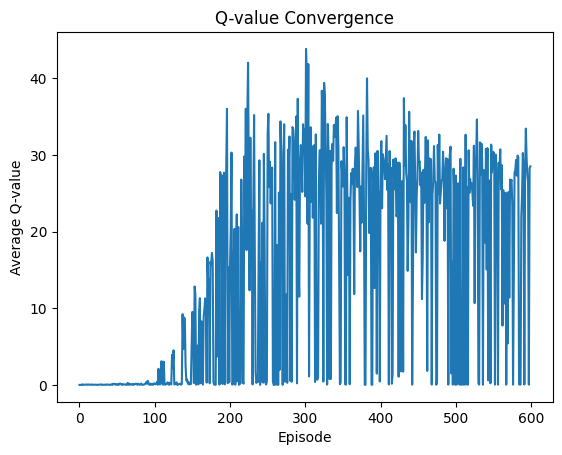

In [58]:

plt.plot(q_values)
plt.xlabel('Episode')
plt.ylabel('Average Q-value')
plt.title('Q-value Convergence')
plt.show()

# Plot Rewards vs episodes(Figure 4. Section 2.4.2)

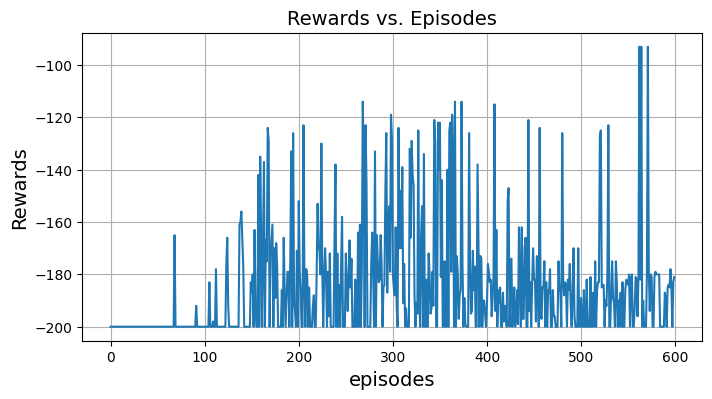

In [62]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("episodes", fontsize=14)
plt.ylabel("Rewards", fontsize=14)
plt.title("Rewards vs. Episodes", fontsize=14)
plt.grid(True)
plt.show()

# Plotting moving average of rewards over the last 50 episodes(Figure 5. Section 2.4.2)

Text(0.5, 1.0, 'Moving average over 50 episodes')

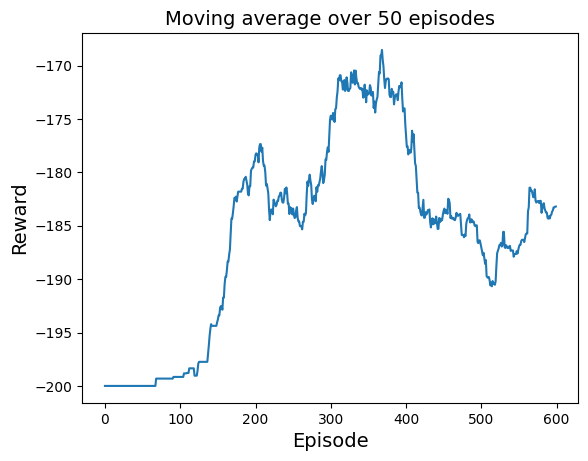

In [63]:
mean_rewards = np.zeros(600)
for t in range(600):
    # plotting the moving average over the last 50 episodes
    mean_rewards[t] = np.mean(rewards[max(0, t-50):(t+1)])
plt.plot(mean_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.title("Moving average over 50 episodes", fontsize=14)

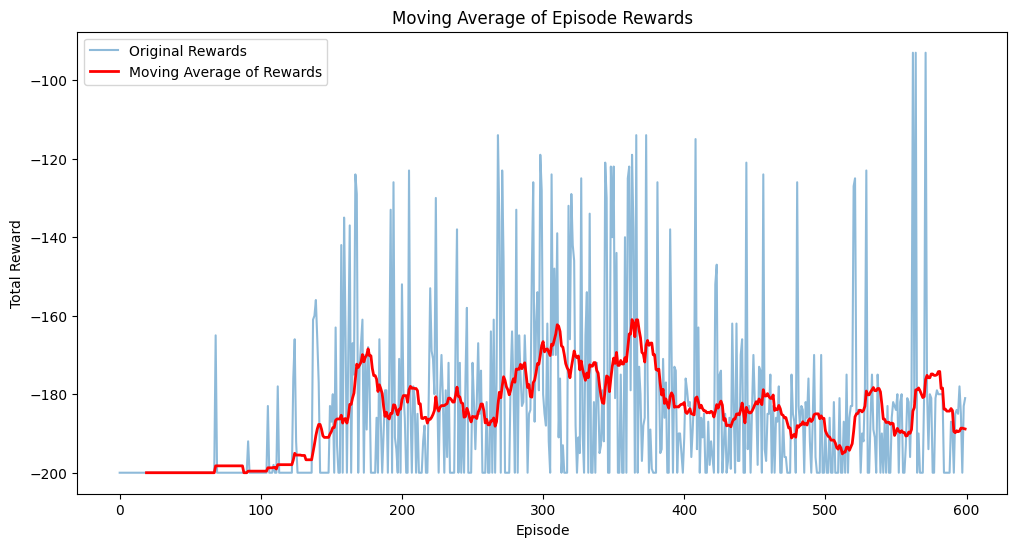

In [64]:
import pandas as pd
rewards_series = pd.Series(rewards)
window_size = 20
rewards_moving_average = rewards_series.rolling(window=window_size).mean()
plt.figure(figsize=(12, 6))
plt.plot(rewards, alpha=0.5, label='Original Rewards')
plt.plot(rewards_moving_average, color='red', linewidth=2, label='Moving Average of Rewards')
plt.title("Moving Average of Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()


## Position vs. Velocity(Figure 6. Section 2.4.2)

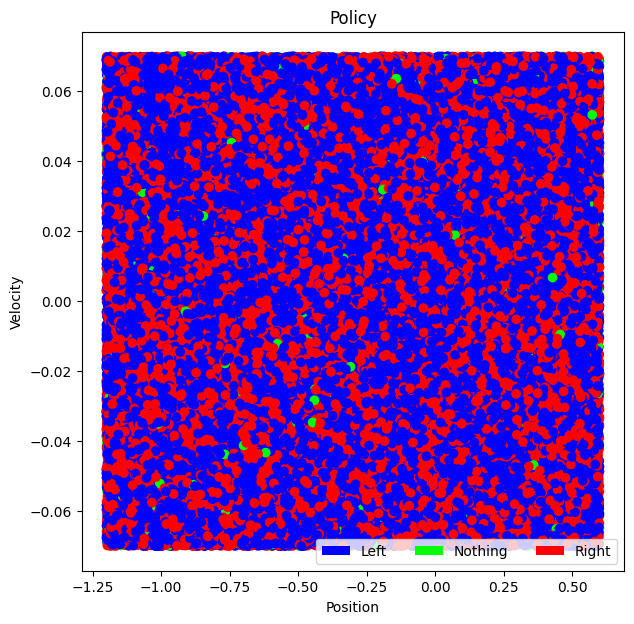

In [67]:
import matplotlib.patches as mpatches
# List of possible positions
X = np.random.uniform(-1.2, 0.6, 111043)
# List of possible velocities
Y = np.random.uniform(-0.07, 0.07, 111043)

# For each possible state, retreive the most rewarding action and record it
actions = []

colors = {0:'blue',1:'lime',2:'red'}
# Convert action_taken to array
actions = np.array(actiion_taken)
# Map action indices to colors
colors = np.array([colors[action] for action in actions])
labels = ['Left',  'Nothing', 'Right']

# Visualize the policy
fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
# Plot scatter plot with X and Y as state[0] and state[1]
surf = ax.scatter(X, Y, c=colors)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
unique_colors = np.unique(colors)
for i in range(len(unique_colors)):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=unique_colors[i]))
plt.legend(recs,labels,loc=4,ncol=3)
plt.show()


<span style='color:green'>The above position vs velocity graph tells us the actions taken by the car at each position and velocity. As expected the car(agent) chose to move left(blue) and right(red) more often than staying and doing nothing(green). This tells us that the agent was constantly moving around except for a fewew occasions where the reward obtained from it doing nothing, outweighed the rewards from moving left or right, as per Bellman Equation.</span>

---------------------------------------------------------------------------------------------

# 3. Double DQN

<span style ='color:red'> There are two problems with vanilla DQN and Fixed DQN -> Maximization bias which is the problem of overestimating the action-values of a state, that is, the agent tends to believe certain actions are valuable even though it is not so. And this happens because we are referring to the same table values to select an action and evaluate that action. -> Catastrophic forgetting   </span>

<span style ='color:red'> The solution to this problem of overestimation is using two different Q tables (that is two different neural network models). 
The best action can be taken based on the first Q table values and tha target value can be taken on the second Q table values </span>

<span style ='color:red'> Training the above two networks (Q1 + Q2) is based on "flip coin" approach (that is decisions are made randomly) and here, the main Q network model (Q1) is used to select the action(a) and the target network model (Q2) is used to evaluate that action(a) for the first half of randomness say when randomness < 0.5 and vice versa when randomness is > 0.5.  </span>

Following this method helps the agent to not overestimate for both the halves of the action values in the Q tables (randomness < 0.5 and randomness > 0.5). </span>



## Importing required packages and libraries

In [1]:
# import imageio
import matplotlib.pyplot as plt
import pandas as pd

In [6]:

random.seed(2212)
np.random.seed(2212)
tf.random.set_seed(2212)

## Defining Hyperparameters

In [7]:
# The number of sequential interacgtions the car has with its environment.
EPISODES = 600
# The size of the experience replay (section ---)
REPLAY_MEMORY_SIZE = 1_00_000
# Minimum size of experience replay required
MINIMUM_REPLAY_MEMORY = 1_000
# The number of sample we fetch from the experience replay during training
MINIBATCH_SIZE = 32
# The hyperparameter which balances exploration and exploitation by agent
EPSILON = 0.1
# The rate at which the epsilon decreases
EPSILON_DECAY = 0.99
MINIMUM_EPSILON = 0.001
# The discount factor which doiscunts future reward in favor of immediate reward (gamma)
DISCOUNT = 0.99
# The number of episodes before run before the learning is recorded
record_frequency = 20

## Defining the Simulated Environment

In [8]:
# The simulated environment used by the agent (car)
ENV_NAME = 'MountainCar-v0'
# Creates an environment
env = gym.make(ENV_NAME)
# Returns dimensionality of action space (0-> push left, 1-> no acceleration, 2-> push right)
action_dim = env.action_space.n
# Returns dimensionality of observation space (position [-1.2, 0.6], velocity[-0.07,0.07])
observation_dim = env.observation_space.shape

## Defining Deep Q Network model and Target Network Model

In [9]:

# Creating simple sequential neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(400, activation='relu', input_shape=observation_dim),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(action_dim, activation='linear')
])

'''Compiling the neural network using Mean Square Error as loss function and
Adam as the optimizer which will learn at a rate of 0.005'''
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
# Creating target network model which is the same as Deep Q network by cloning it
target_model1 = tf.keras.models.clone_model(model)

/Users/Sajin/MultiPDFchatMistral-7B/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Defining Epsilon Greedy Policy

In [10]:
'''Defining epsilon greedy policy function to determine an action
to decide whether to explore or exploit the knowledge acquired'''
def epsilon_greedy_policy(state, epsilon):
    # Explore if random value from uniform distribution is less than exploration factor epsilon
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, action_dim)
        return action
    else:
    # Exploit
        action = np.argmax(model.predict(np.expand_dims(state, axis=0), verbose=0)[0])
        return action

## Defining the step function

In [11]:
max_reward = -999999


'''This function defines the steps the agent has to take based on the epsilon greedy policy
 and accumulates the reward'''
def play_one_step(env, state, epsilon, episode_length):
    # defining reward acquired in each episode
    global episode_reward
    # Calling epsilon greedy function to select action
    action = epsilon_greedy_policy(state, epsilon)
    # Executing the action and returns 4 values
    next_state, reward, done, info = env.step(action)
    # accumulating rewards in each step of the epsiode(max=-200)
    episode_reward += reward
    # truncating if the car reaches the flag on the mountain top within 200 steps
    if done and episode_length < 200:
        # If episode is ended then we have won the game. Defining Stratagem to make the agent learn faster
        reward = 250 + episode_reward
        # save the model weights if we get a epsiode reward greater than maximum reward defined
        if(episode_reward > max_reward):
            print("Saving the model with reward", episode_reward)
            model.save_weights("agent"+str(episode_reward)+"_agent_.weights.h5")
    else:
        # In oher cases reward will be proportional to the distance that car has travelled
        # from it's previous location + velocity of the car
        reward = 5*abs(next_state[0] - state[0]) + 3*abs(state[1])

    # append this result to the replay buffer(experince replay)
    replay_buffer.append((state, action, reward, next_state, done))

    return next_state, episode_reward, max_reward, done, info

## Sampling experience and Training function

In [12]:
# Replay memory (experience replay) to store experiances of the model with the environment
replay_buffer = deque(maxlen=REPLAY_MEMORY_SIZE)
rewards = []

def training_step(MINIBATCH_SIZE):
    # Samples batches of size MiniBatch_size(32) from  the replay buffer
    minibatch = random.sample(replay_buffer, MINIBATCH_SIZE)
    # Array containing current state values from each sample in the minibatch as the replay buffer looks like (state, action, reward, next_state, done)
    X_cur_states = np.array([sample[0] for sample in minibatch])
    # Array containing next state values from each sample in the minibatch as the replay buffer looks like (state, action, reward, next_state, done)
    X_next_states = np.array([sample[3] for sample in minibatch])
    # Predicting the action using main neural network 
    '''The inputs for the Neural Network selecting the action using main network.
    This uses the main neural network model to predict the current Q-values for all actions given the current states'''
    cur_action_values = model.predict(X_cur_states, verbose=0)
    ''' This step predicts the Q-values for the next states using the same main network and
    helps to decide the next action to take'''
    # Q1(a)
    next_action_values_main = model.predict(X_next_states, verbose=0)
    # Evaluating the action using target network
    ''' This uses a separate target network to predict the Q-values for the next states. 
    This target network is an older version of the main network and is used to stabilize the training'''
    # Q2(a)
    next_action_values_target = target_model1.predict(X_next_states, verbose=0)
    # This loop iterates over each sample from sample experience
    for index, (cur_state, action, reward, next_state, done) in enumerate(minibatch):
        # If the episode is not completed,
        if not done:
            ''' Using "coin flip" approach to randomly select the networks to be used 
            for predicting an action and evaluate the selected action during training'''
            if np.random.rand() < 0.5:
                # Return action with highest Q value in next state as per the main neural network
                # The below are from Reinforcement Learning An Introduction Second Edition Page 135
                # Q2(A*) = Q2(argmax(Q1(a)))
                best_action_next = np.argmax(next_action_values_main[index])
                ''' The bellman equation is updated to to return Q value for the action taken using reward, 
                discount and best next action from the target network and not the main network'''
                # E|Q2(A*)| = q(A*)
                cur_action_values[index][action] = reward + DISCOUNT * next_action_values_target[index][best_action_next]
            else:
                # Q1(A*) = Q1(argmax(Q2(a)))
                best_action_next = np.argmax(next_action_values_target[index])
                ''' The bellman equation is updated to to return Q value for the action taken using reward, 
                discount and best next action from the target network and not the main network'''
                # E|Q1(A*)| = q(A*)
                cur_action_values[index][action] = reward + DISCOUNT * next_action_values_main[index][best_action_next]      
        else:
            cur_action_values[index][action] = reward
    # updates model weights using Q values to minimize the error between target value and predicted value.
    model.fit(X_cur_states, cur_action_values, verbose=0)

## Running the episodes

In [13]:
episode_lengths = [] 
# Looping through episodes
for episode in range(EPISODES):
    # resetting the environment for the state to be reset
    state = env.reset()
    # initializing variables used
    done = False
    episode_reward = 0
    episode_length = 0
    # creating a list to capture and append the learning through animation
    frames = []

    # Running through different sets of steps
    while not done:
        # incrementing episode length(number of steps)
        episode_length += 1
        # calling the play_one_step function to execute the steps
        next_state, reward, max_reward, done, info  = play_one_step(env,state, EPSILON, episode_length)
        # update the current state with the next state for the episode to continue
        state = next_state

        # Checking if the replay buffer size is less than the minimum required replay buffer size for training to start
        if(len(replay_buffer) < MINIMUM_REPLAY_MEMORY):
            continue
        # when the minimum replay buffer size is populated
        training_step(MINIBATCH_SIZE)

        # Recording and collecting the learning through frames for every 20 episodes
        # if episode % record_frequency ==0:
        #     frames.append(env.render(mode='rgb_array'))

    # Creating learning animation
    # if episode % record_frequency ==0:
    #         imageio.mimsave(f'episode_{episode}.mp4', frames, fps=30)

    # recording the values for visualizing the results
    max_reward = max(reward, max_reward)
    print('Episode', episode, 'Episodic Reward', reward, 'Maximum Reward', max_reward, 'EPSILON', EPSILON)
    rewards.append(reward)

    # Saving the weights for the episode that received maximum reward
    if episode % 20 == 0:
        target_model1.set_weights(model.get_weights())
    # Epsilon decay for the next episode
    if(EPSILON > MINIMUM_EPSILON and len(replay_buffer) > MINIMUM_REPLAY_MEMORY):
        EPSILON *= EPSILON_DECAY

    # recording the number of time steps taken by agent from the beginning of an episode to its termination
    episode_lengths.append(episode_length)

Episode 0 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 1 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 2 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 3 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 4 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 5 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 6 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.099
Episode 7 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.09801
Episode 8 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.0970299
Episode 9 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.096059601
Episode 10 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.09509900499
Episode 11 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.0941480149401
Episode 12 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.093206534790699
Episode 13 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.0922

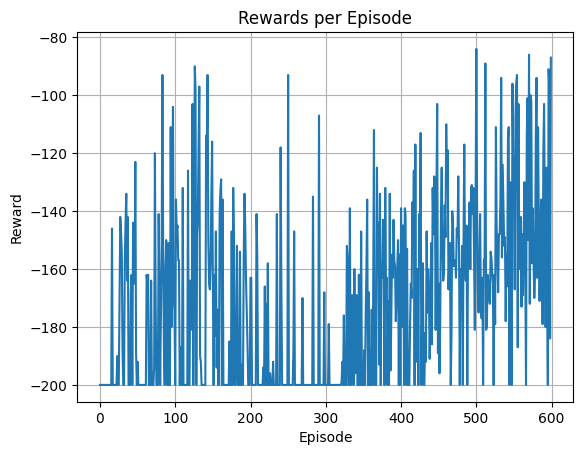

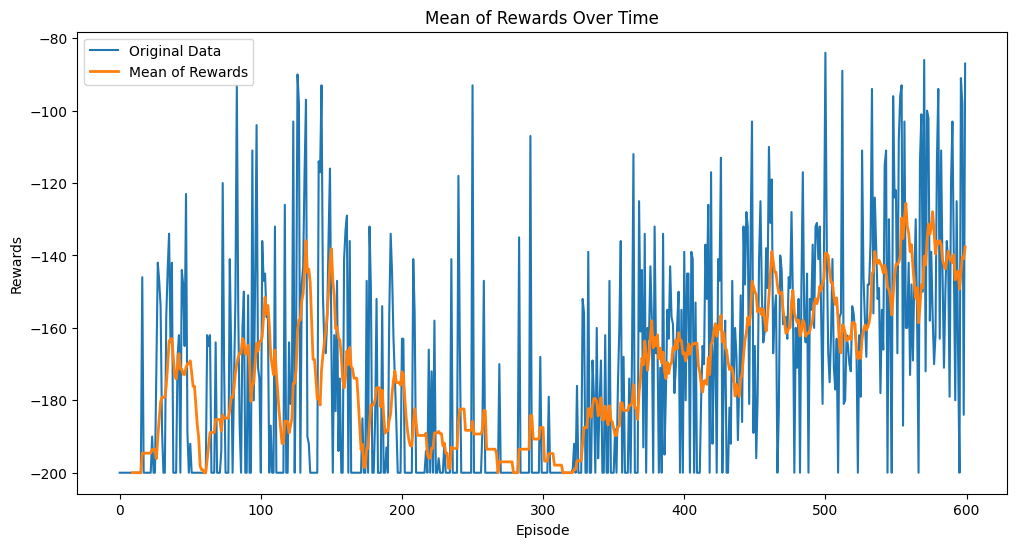

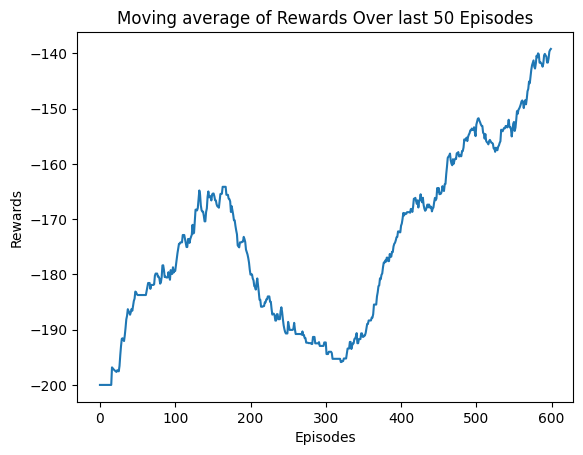

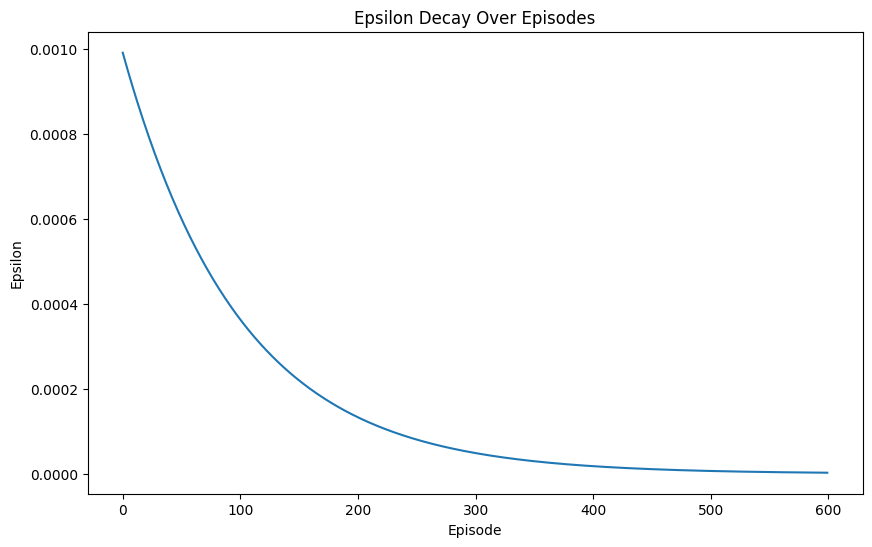

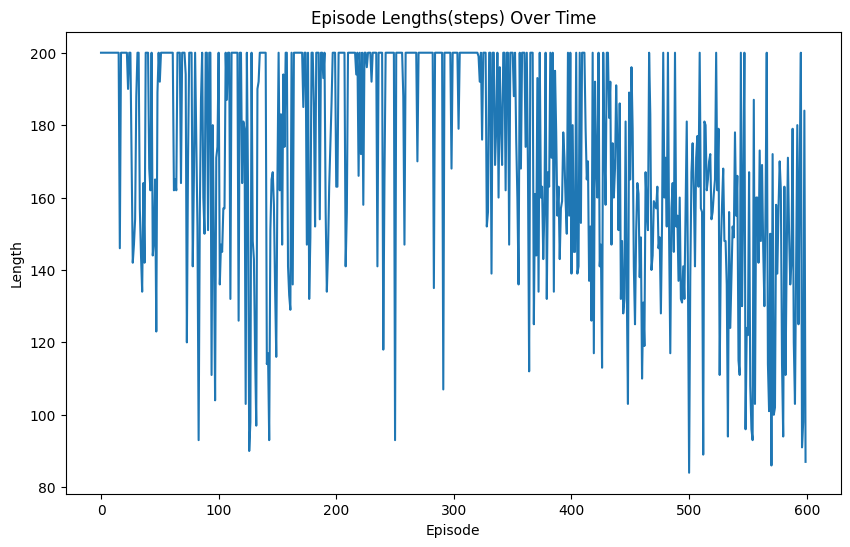

In [15]:
# plot Rewards vs Episodes
plt.plot(rewards)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

# plot Mean of Rewards with window size 10
data = rewards
data_series = pd.Series(data)
window_size = 10
moving_average = data_series.rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(data, label='Original Data')
plt.plot(moving_average, label='Mean of Rewards', linewidth=2)
plt.title("Mean of Rewards Over Time")
plt.xlabel("Episode")
plt.ylabel("Rewards")
plt.legend()
plt.show()

# plot Movig average of rewards over 600 episodes with window size 50
mean_rewards = np.zeros(600)
for t in range(600):
    mean_rewards[t] = np.mean(rewards[max(0,t-50):(t+1)])
plt.plot(mean_rewards)
plt.title("Moving average of Rewards Over last 50 Episodes")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()


# plot Epsilon Decay Over Episodes
epsilons = [EPSILON * (EPSILON_DECAY ** episode) for episode in range(EPISODES)]

# plot Episode Lengths Over Time
plt.figure(figsize=(10, 6))
plt.plot(epsilons)
plt.title("Epsilon Decay Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.show()

# plot Episode Lengths Over Time
plt.figure(figsize=(10, 6))
plt.plot(episode_lengths)
plt.title("Episode Lengths(steps) Over Time")
plt.xlabel("Episode")
plt.ylabel("Length")
plt.show()

In [ ]:
# Replay memory (experience replay) to store experiances of the model with the environment
replay_buffer = deque(maxlen=REPLAY_MEMORY_SIZE)
rewards = []

def training_step(MINIBATCH_SIZE):
    # Samples batches of size MiniBatch_size(32) from  the replay buffer
    minibatch = random.sample(replay_buffer, MINIBATCH_SIZE)
    # Array containing current state values from each sample in the minibatch as the replay buffer looks like (state, action, reward, next_state, done)
    X_cur_states = np.array([sample[0] for sample in minibatch])
    # Array containing next state values from each sample in the minibatch as the replay buffer looks like (state, action, reward, next_state, done)
    X_next_states = np.array([sample[3] for sample in minibatch])
    # Predicting the action using main neural network 
    '''The inputs for the Neural Network selecting the action using main network.
    This uses the main neural network model to predict the current Q-values for all actions given the current states'''
    cur_action_values = model.predict(X_cur_states, verbose=0)

    '''The inputs for the Neural Network selecting the action using target network.
    This uses the target neural network model to predict the current Q-values for all actions given the current states'''
    cur_action_values_target = target_model1.predict(X_cur_states, verbose=0)
    ''' This step predicts the Q-values for the next states using the same main network and
    helps to decide the next action to take'''
    # Q1(a)
    next_action_values_main = model.predict(X_next_states, verbose=0)
    # Evaluating the action using target network
    ''' This uses a separate target network to predict the Q-values for the next states. 
    This target network is an older version of the main network and is used to stabilize the training'''
    # Q2(a)
    next_action_values_target = target_model1.predict(X_next_states, verbose=0)
    # This loop iterates over each sample from sample experience
    for index, (cur_state, action, reward, next_state, done) in enumerate(minibatch):
        # If the episode is not completed,
        if not done:
            ''' Using "coin flip" approach to randomly select the networks to be used 
            for predicting an action and evaluate the selected action during training'''
            if np.random.rand() < 0.5:
                # Return action with highest Q value in next state as per the main neural network
                # Q2(A*) = Q2(argmax(Q1(a)))
                best_action_next = np.argmax(next_action_values_main[index])
                ''' The bellman equation is updated to to return Q value for the action taken using reward, 
                discount and best next action from the target network and not the main network'''
                # E|Q2(A*)| = q(A*)
                cur_action_values[index][action] = reward + DISCOUNT * next_action_values_target[index][best_action_next]
            else:
                # Q1(A*) = Q1(argmax(Q2(a)))
                best_action_next = np.argmax(next_action_values_target[index])
                ''' The bellman equation is updated to to return Q value for the action taken using reward, 
                discount and best next action from the target network and not the main network'''
                # E|Q1(A*)| = q(A*)
                cur_action_values_target[index][action] = reward + DISCOUNT * next_action_values_main[index][best_action_next]      
        else:
            cur_action_values[index][action] = reward
    # updates model weights using Q values to minimize the error between target value and predicted value.
    model.fit(X_cur_states, cur_action_values, verbose=0)
    target_model1.fitl(X_cur_states, cur_action_values_target, verbose=0)

In [ ]:
episode_lengths = [] 
# Looping through episodes
for episode in range(EPISODES):
    # resetting the environment for the state to be reset
    state = env.reset()
    # initializing variables used
    done = False
    episode_reward = 0
    episode_length = 0
    # creating a list to capture and append the learning through animation
    frames = []

    # Running through different sets of steps
    while not done:
        # incrementing episode length(number of steps)
        episode_length += 1
        # calling the play_one_step function to execute the steps
        next_state, reward, max_reward, done, info  = play_one_step(env,state, EPSILON, episode_length)
        # update the current state with the next state for the episode to continue
        state = next_state

        # Checking if the replay buffer size is less than the minimum required replay buffer size for training to start
        if(len(replay_buffer) < MINIMUM_REPLAY_MEMORY):
            continue
        # when the minimum replay buffer size is populated
        training_step(MINIBATCH_SIZE)

        # Recording and collecting the learning through frames for every 20 episodes
        # if episode % record_frequency ==0:
        #     frames.append(env.render(mode='rgb_array'))

    # Creating learning animation
    # if episode % record_frequency ==0:
    #         imageio.mimsave(f'episode_{episode}.mp4', frames, fps=30)

    # recording the values for visualizing the results
    max_reward = max(reward, max_reward)
    print('Episode', episode, 'Episodic Reward', reward, 'Maximum Reward', max_reward, 'EPSILON', EPSILON)
    rewards.append(reward)

    # Saving the weights for the episode that received maximum reward
    # if episode % 20 == 0:
    #     target_model1.set_weights(model.get_weights())
    # Epsilon decay for the next episode
    if(EPSILON > MINIMUM_EPSILON and len(replay_buffer) > MINIMUM_REPLAY_MEMORY):
        EPSILON *= EPSILON_DECAY

    # recording the number of time steps taken by agent from the beginning of an episode to its termination
    episode_lengths.append(episode_length)